# Plotting Cloud-top Height vs. Albedo

We aim for an ISCCP-type plot diagram where albedo is shown as cloud-optical thickness porxy on x-axis and cloud-top height on y-axis.

This is just done for the time slot shown in the paper.

In [1]:
%matplotlib inline

## Import LIbs

### Standard Libs

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import pylab as plt
import seaborn as sns
sns.set_context( 'talk' )

### Project Libs

In [3]:
import nawdex_analysis.io.selector
import nawdex_analysis.io.collector
from nawdex_analysis.config import nawdex_dir
print(nawdex_dir)

/vols/fs1/store/senf/data/icon/nawdex/


## Input of CT and CTH data

The input of CTH data is not included in the standard version of my `nawdex_analysis` package. For an easy appraoch, we patch the respective function, i.e. `nawdex_analysis.io.input_lev2.collect_data4cre_obs`.

In [4]:
# %load ../../2018-05_pypackage_devel/nawdex_analysis/nawdex_analysis//io/input_lev2.py
#!/usr/bin/env python

'''
Tools for input of simulated data.
'''

import os, sys, copy
import numpy as np
import datetime
import xarray as xr
import scipy.ndimage

import tropy.io_tools.hdf as hio
import tropy.io_tools.netcdf as ncio
import tropy.analysis_tools.grid_and_interpolation as gi

from nawdex_analysis.config import nawdex_dir
from nawdex_analysis.config import nawdex_regions_file
from nawdex_analysis.io.tools import convert_time
from nawdex_analysis.io import selector
from nawdex_analysis.io.input_lev2 import *


def collect_data4cre_obs( radname, itime, filepart = '-scaled', lwf_clear_offset = -2. ):
    
    '''
    Collects a set of observed data fields for cloud-radiative effect analysis.  
    

    Parameters
    ----------
    radname : str
       name of toa allsky radiation file

    itime : int
       time index of data fields ('swf_net' and 'lwf') in radname
    
    filepart : str, optional, default = '-scaled'
       part in the file that gives information about scaling of clear-sky fields
       either '-scaled' or '-not_scaled'

    lwf_clear_offset : float, optional, default = 2.
       due to the bias in the simulated LWF, we might use an predefined offset
       to correct this issue
       i.e. LWF_clear_simulated += lwf_clear_offset


    Returns
    --------
    dset : dict
       dataset dict containing swf, lwf and ct fields
    '''

    # set filenames
    # ==============
    clearname = radname.replace('toa_', 'toa_clear_')
    ctname = radname2ctname( radname, datatype = 'obs' )


    # read allsky data
    # =================
    dset = {}
    for vname in ['lwf', 'swf_net', 'swf_up']:
        radset = read_data_field(radname, itime, vname, region='atlantic')
        dset[vname] = radset[vname]

    dset['swf_down'] = dset['swf_net'] - dset['swf_up']
        
        
        
    
    # find the right short-wave clear file
    # ===================================
    tobj = radset['time_obj']
    filemap = selector.make_filetime_index('swf_net', tobj, 
                                                filepart = filepart, 
                                                subdirs=['retrieved_clearsky_netswf'])

    # print filemap    

    # input swf clear
    # ===============
    clearname = filemap[tobj][0]
    clearset = read_data_field(clearname, tobj, 'swf_net', region ='atlantic')
    dset['swf_net_clear'] = clearset['swf_net']    
    dset['swf_up_clear'] = dset['swf_net_clear'] - dset['swf_down']



    # long-wave filename
    # ====================
    lwfclearname = clearname.replace('retrieved_clearsky_netswf/clearsky_netswf-', 'sim-toarad/toa_clear_radflux-' )
    lwfclearname = lwfclearname.replace(filepart,'')

    print((radname, clearname, lwfclearname))


    # input lwf clear data
    # ====================
    if filepart == '-not_scaled':
        lwf_clear_offset = 0

    lwfclearset = read_data_field(lwfclearname, tobj, 'lwf', region ='atlantic')
    dset['lwf_clear'] = lwfclearset['lwf'] + lwf_clear_offset
    


    # input cloud type
    # ====================
    ctset = read_data_field( ctname, tobj, 'CT', region = 'atlantic')    
    dset.update( ctset )

    cthset = read_data_field( ctname, tobj, 'CTTH_HEIGHT', region = 'atlantic')    
    dset.update( cthset )



    # select and modify region mask
    # ==============================
    region_mask = dset['mask']
        
    # possible extension (get away from coast)
    nedge = 11
    region_mask = scipy.ndimage.minimum_filter( region_mask, nedge)


    # finally prepare georef
    # =======================
    mlon =  dset['lon'][region_mask].mean()
    mlat =  dset['lat'][region_mask].mean()

    x, y = gi.ll2xyc( dset['lon'], dset['lat'], mlon = mlon, mlat = mlat )
    a = gi.simple_pixel_area(x, y, xy = True)

    # update mask and area
    dset['mask'] = region_mask
    dset['area'] = a
        
    return dset
                
######################################################################
######################################################################



In [5]:
radname = '{}/gerb-like/toa_radflux-nawdex-20160923.nc'.format( nawdex_dir )
d = collect_data4cre_obs( radname, 12 )

.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
('/vols/fs1/store/senf/data/icon/nawdex//gerb-like/toa_radflux-nawdex-20160923.nc', '/vols/fs1/store/senf/data/icon/nawdex//retrieved_clearsky_netswf/clearsky_netswf-nawdexnwp-10km-mis-0001-scaled.nc', '/vols/fs1/store/senf/data/icon/nawdex//sim-toarad/toa_clear_radflux-nawdexnwp-10km-mis-0001.nc')
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5


/vols/fs1/store/senf/.conda/python27mod/lib/python2.7/site-packages/tropy/analysis_tools/grid_and_interpolation.py:990: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if not np.rank(lon) == 2 and not np.rank(lat) == 2:


## Average Statistics

We calculate the average and standard deviation for each cloud type.

### Histograms

In [6]:
def get_hist_for_ct( d, vname, bins ):
    
    m = d['mask']
    ct = d['CT']
    
    v = d[vname]
    
    ct_map = [2, 6, 8, 10, 12, 14, 15, 16, 17, 18, 19]
    
    ct_labels = [ 'clear_ocean',  'very low', 'low', 'middle', 'high opaque', 
                                 'very high opaque', 'semi. thin', 'semi. meanly thick', 
                                 'semi. thick', 'semi. above', 'fractional'
                             ] 

    
    hist = np.zeros((len(bins) - 1, len(ct_labels)))

    cbins = 0.5* (bins[1:] + bins[:-1])
    
    for n, itype in enumerate(ct_map):
        
        h, xe = np.histogram( v[m & (ct == itype)], bins )
        hist[:,n] = h[:] / (1. * h.sum() )
        
        
    outset = xr.Dataset({'ct' : ('ct', ct_labels, {}), 'bin_edge' : ('bin_edge', bins, {}),
                         'bin_mid' : ('bin_mid', cbins, {}),
                         'hist' : (('bin_mid', 'ct'), hist, {'longname':'relative counts'}) } )
    
    return outset

### Average and STD

In [7]:
def get_stats_for_ct( d, vname ):
    
    m = d['mask']
    ct = d['CT']
    
    v = d[vname]
    
    ct_map = [2, 6, 8, 10, 12, 14, 15, 16, 17, 19]
    
    ct_labels = [ 'clear_ocean',  'very low', 'low', 'mid-level', 'high opaque', 
                                 'very high opaque', 'semi. thin', 'semi. moderately thick', 
                                 'semi. thick', 'fractional'
                             ] 

    
    vmean = []
    vstd = []
    
    for n, itype in enumerate(ct_map):
        
        vmean += [ np.mean( v[m & (ct == itype)]) ,]
        vstd  += [ np.std( v[m & (ct == itype)])  ,]
        
    outset = xr.Dataset({'ct' : ('ct', ct_labels, {}), 
                         'mean' : (('ct'), vmean, {'longname':'average'}),
                         'std' : (('ct'), vstd, {'longname':'standard deviation'}) } )
    
    return outset

In [8]:
d['albedo'] = d['swf_up'] / np.abs( d['swf_down'])

In [9]:
dmean = xr.Dataset()
dstd = xr.Dataset()

for vname in  ['CTTH_HEIGHT', 'albedo']:
    dmean[vname] = get_stats_for_ct( d, vname)['mean']
    dstd[vname] = get_stats_for_ct( d, vname)['std']


## Mapping into ISCCP categories

### Temperature & Pressure Profiles

We directly read the ECMWF Forecast for that day

In [10]:
import tropy.ECMWFtools

In [11]:
ecmwf_file = '{}/data/ecmwf/fd/2016/09/23/ecmwf-fd-20160923t0000z-12h.grb'.format( os.environ['LHOME'])

In [12]:
ecmwf_file

'/vols/fs1/store/senf/data/ecmwf/fd/2016/09/23/ecmwf-fd-20160923t0000z-12h.grb'

In [13]:
lon, lat, lev, t = tropy.ECMWFtools.get_grib_field_lll( ecmwf_file, 't')

In [14]:
fcset = tropy.ECMWFtools.get_fc_fields( ecmwf_file, ['t', 'z'], lonlat = True )

... reading t
... reading z


/vols/fs1/store/senf/.conda/python27mod/lib/python2.7/site-packages/tropy/ECMWFtools.py:267: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(var) == 3:


### Mapping

In [15]:
import tropy.analysis_tools.grid_and_interpolation as gi

In [16]:
#ind = gi.create_interpolation_index( d['lon'], d['lat'], fcset['lon'], fcset['lat'])

We sample $N = 1000$ points which are inside the considered area.

In [17]:
m = d['mask']
rind = np.random.randint( np.sum(m), size = 1000 )

In [18]:
ind = gi.create_interpolation_index( fcset['lon'], fcset['lat'], d['lon'][m][rind], d['lat'][m][rind] )

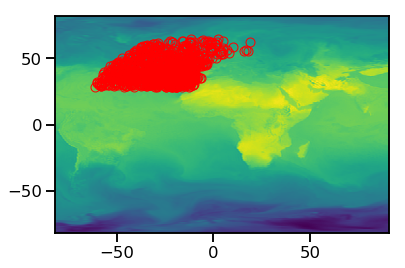

In [19]:
plt.pcolormesh( fcset['lon'], fcset['lat'], fcset['t'][:,:,-1])
plt.plot( fcset['lon'][ind], fcset['lat'][ind], 'ro', fillstyle = 'none')

### Averages

In [38]:
Z = fcset['z'][ind].mean(axis = 0)[1:] / 9.81
T = fcset['t'][ind].mean(axis = 0)
for l in range( len( lev) ):
    print(l, lev[l], Z[l])

(0, 10.0, 31160.567278287457)
(1, 30.0, 23973.810295616717)
(2, 50.0, 20722.81111111111)
(3, 70.0, 18614.55973496432)
(4, 100.0, 16409.452905198777)
(5, 150.0, 13915.399082568807)
(6, 200.0, 12112.557951070336)
(7, 250.0, 10668.154179408766)
(8, 300.0, 9444.148318042813)
(9, 400.0, 7414.053555045871)
(10, 500.0, 5750.013000127421)
(11, 700.0, 3104.6345087920486)
(12, 850.0, 1510.1855600152905)
(13, 925.0, 802.7759429153924)
(14, 1000.0, 141.15851809378185)


In [21]:
lev.shape, Z.shape, T.shape

((15,), (15,), (15,))

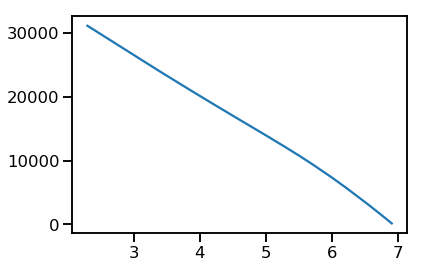

In [41]:
plt.plot(np.log(lev), Z )

### Setting Interpolation Functions

In [22]:
import scipy.interpolate

In [23]:
zfunc = scipy.interpolate.interp1d( lev, Z, kind = 'linear')


In [24]:
zfunc([680, 440])

array([3369.17235793, 6748.43733308])

In [25]:
zfunc_T = scipy.interpolate.interp1d( T, Z, kind = 'linear')
zfunc_T([273.15, 273.15 -40])

array([ 3596.9391664 , 11099.27069343])

In [26]:
T

array([227.28079687, 219.47277417, 215.52580347, 212.66067041,
       210.25412   , 211.40603259, 217.4983623 , 225.39599182,
       233.63422839, 248.80729553, 260.5382124 , 276.03371057,
       283.47718188, 286.16093213, 290.97384595])

### Setting Interpolation Functions based on Log(p)

In [43]:
zfunc_log = scipy.interpolate.interp1d( np.log(lev), Z, kind = 'linear')


In [47]:
plevs = np.array([800, 650, 450, 300]) # these are the heights that divide different NWCSAF CTs
log_plevs = np.log( plevs )

In [49]:
nwcsaf_heights = zfunc_log( log_plevs )
print( nwcsaf_heights)

[2008.04736874 3687.27882305 6535.71426691 9444.14831804]


In [54]:
Tfunc = scipy.interpolate.interp1d( Z, T, kind = 'linear')
Tfunc( nwcsaf_heights) - 273.15

array([  8.00298073,  -0.52917115, -18.15071285, -39.51577161])

### Albedo Mapping

In [27]:
def cahalan_eq3_8_inverted( R ):
    
    gam = 0.1
    
    return 1 / gam * R / (1. - R )

def cahalan_eq3_8( tau ):
    
    gam_tau = 0.1 * tau    

    return gam_tau / (1. + gam_tau)


In [28]:
cahalan_eq3_8( 10 )

0.5

In [29]:
cahalan_eq3_8( np.array( [3,23] ) )

array([0.23076923, 0.6969697 ])

## Plotting Fields

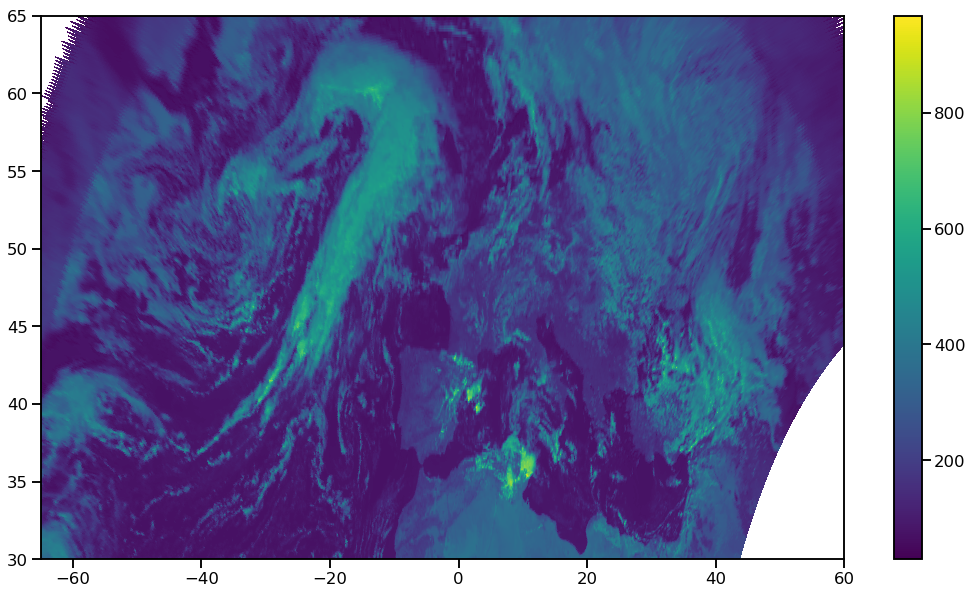

In [30]:
nan = np.isnan( d['lon'])
d['lon'][nan] = 91
d['lat'][nan] = 91

plt.figure( figsize = (18,10))
plt.pcolormesh(d['lon'], d['lat'], d['swf_up'])
plt.ylim(30, 65)
plt.xlim(-65, 60)
plt.colorbar()

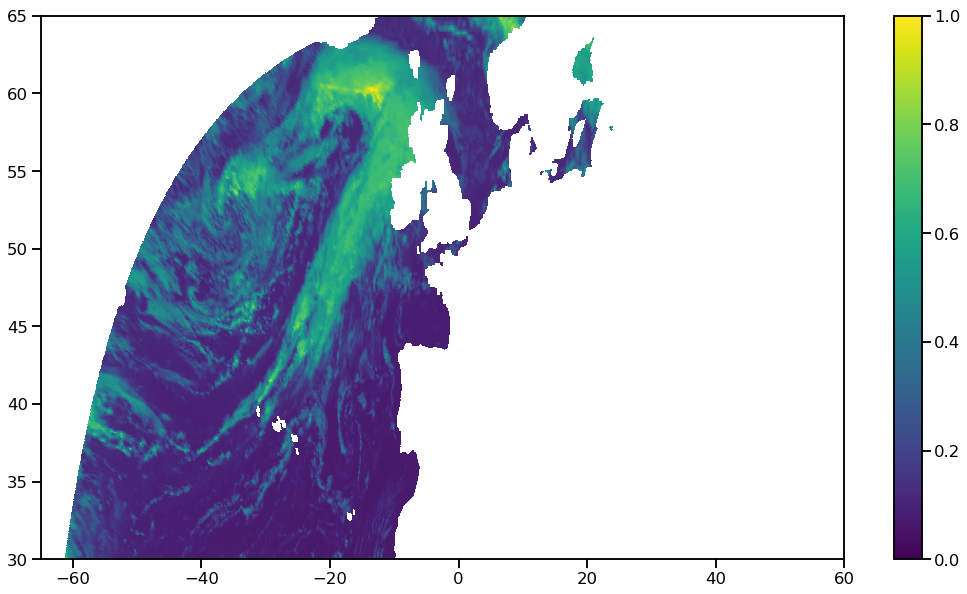

In [31]:
nan = np.isnan( d['lon'])
d['lon'][nan] = 91
d['lat'][nan] = 91

plt.figure( figsize = (18,10))
plt.pcolormesh(d['lon'], d['lat'], np.ma.masked_where( ~d['mask'], d['albedo']), vmin = 0, vmax = 1.)
plt.ylim(30, 65)
plt.xlim(-65, 60)
plt.colorbar()

## Scatter Plotting

We make an ISCCP-type of plot with albedo on x-axis and CTH on y-axis.

In [32]:
def errplot_ave_vars( mvar, dvar, vname1, vname2, isccp = True ):
    
    ctlist = list( mvar['ct'].data )
    
    for i, ctname in enumerate( ctlist ):
    
        try:
            label = ctname

            d = mvar.sel(ct = ctname)
            derr = dvar.sel(ct = ctname)


            kws = dict( color = 'k', marker = 'o', ms = 0, linewidth = 0)
            plt.plot( d[vname1].data, d[vname2].data, label = '{}  {}'.format(i, ctname), **kws)
            
            kws = dict( color = 'k', marker = 'o', ms = 25, mec = 'w', mew =1.)
            plt.plot( d[vname1].data, d[vname2].data,  **kws)

            #kws = get_exp_kws( idname, ptype = 'lines' )
            plt.errorbar( d[vname1].data, d[vname2].data, xerr = derr[vname1], yerr = derr[vname2], **kws)
            
            if np.isfinite(d[vname1].data): 
                xoffset = 5e-4
                yoffset = -50
                plt.text( d[vname1].data + xoffset, d[vname2].data + yoffset, str( i  ),  
                         color = "white", 
                         fontsize = 16, 
                         va = 'center', 
                         fontweight = 'bold',
                         ha = 'center')
                
            #pl.plot( [do[vname1], d[vname1]], 
            #         [do[vname2], d[vname2]], color='gray', alpha = 0.3, lw = 2)

        except:
            pass
    
    if isccp:
        zlow = 3400
        zmid = 6800
        ztop = 15e3
        
        plt.xlim(0,0.9)
        plt.ylim(-1e3, ztop)
        kws = dict( color = 'gray', alpha = 0.3, lw = 5)
        
        plt.axhline( zlow, **kws)
        plt.axhline( zmid, **kws)
        plt.axvline(x = 0.5, ymin = 0.28, ymax = 1., **kws)
        
        plt.axhspan(0, zlow, color = 'darkgreen', alpha = 0.1)
        plt.axhspan(zlow, zmid,  color = 'orange', alpha = 0.1)
        plt.axhspan(zmid, ztop- 2e3,  color = 'brown', alpha = 0.1)

        kws = dict(color = 'gray', ha = 'center', fontsize = 18, fontweight = 'bold', alpha = 0.6)
        
        plt.text( 0.8, 10e3, 'high', **kws)
        plt.text( 0.8, 5e3, 'mid-level', **kws)
        plt.text( 0.8, 1.6e3, 'low', **kws)
        
        plt.text( 0.25, 14e3, 'thin', **kws)
        plt.text( 0.7, 14e3, 'thick', **kws)
        
        
        
    return

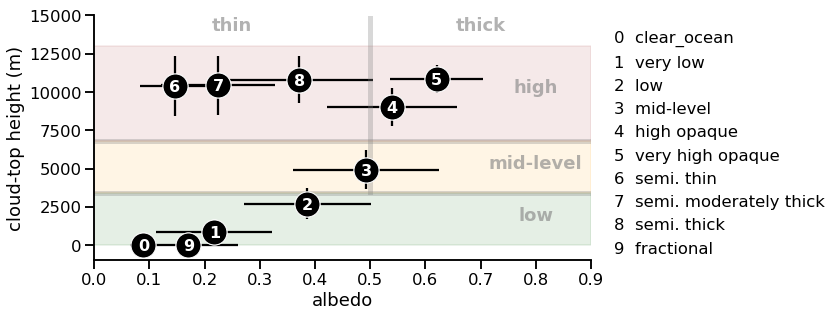

In [33]:
fig = plt.figure(figsize = (12,5))
plt.subplots_adjust( right = 0.7, bottom = 0.2)
errplot_ave_vars( dmean, dstd, 'albedo', 'CTTH_HEIGHT')
plt.xlabel('albedo')
plt.ylabel('cloud-top height (m)')
sns.despine()
plt.legend( loc = 'upper right', bbox_to_anchor=(1.5, 1.), frameon = False)
plt.savefig('../pics/ctype-like-isccp.png', dpi = 300)